### Library Install 
##### 설치 후 Restart Kernel 후 다음 step 진행

### Ignore warnings
코드 실행에서 불필요한 경고 문구 해제 

In [1]:
import warnings 
warnings.filterwarnings('ignore')

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

### Library Import
코드 실행에 필요한 라이브러리를 호출

In [1]:
import rdkit
import py3Dmol
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule, MMFFOptimizeMolecule
from rdkit.Chem import AllChem, Draw, Descriptors, MACCSkeys, rdMolDescriptors
from rdkit.Chem import rdDepictor, rdDistGeom
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

from torch_geometric.utils import smiles
# from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer

print(rdkit.__version__)

2024.03.6


## 1) 분자의 데이터 표기법
분자는 화학적으로 결합된 두 개 이상의 원자로 이루어진 물질의 가장 작은 단위로, 해당 물질의 화학적 성질을 유지하며 독립적으로 존재할 수 있다.

이러한 화학 물질은 상황에 따라 다양한 용어로 불리는데, 예를 들어 분자(Molecule), 화합물(Compound), 약물(Drug) 등으로 구분된다.

예시를 들어, 대표 항생제로 알려진 __"페니실린"__ 은 세균 감염을 치료하는데 사용되는 중요한 약물질이다.

페니실린의 분자 구조가 어떻게 생겼는지와 어떤 식으로 표기하여 사용되고 있는지 확인해보자.
 
아래 항목은 화학 물질이나 약물을 데이터로 표기할 때 사용하는 표준 정보들에 대한 설명이다.

* Generic Name: 일반적으로 사용되는 명칭
* Formula: 분자의 원자 구성과 비율을 나타낸 화학식
* IUPAC Name: 국제순수화학연합(IUPAC)이 권장하는 화학 명명법에 따른 공식 이름
* CAS RN (Chemical Abstracts Service Registry Number): 특정 화합물(분자)을 식별하기 위한 고유 번호
* SMILES (Simplified Molecular Input Line Entry System): 화합물의 구조를 텍스트로 나타내는 선형 표기법
* InChI (International Chemical Identifier): 화학 구조를 표현하기 위해 사용하는 기계가 읽을 수 있는 표준 코드

Molecule Data:
Generic Name: Penicillin
Formula: C16H18N2O4S
IUPAC Name: (2S,5R,6R)-3,3-dimethyl-7-oxo-6-[(2-phenylacetyl)amino]-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid
CAS RN: 61-33-6
SMILES: CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C
InChI: InChI=1S/C16H18N2O4S/c1-16(2)12(15(21)22)18-13(20)11(14(18)23-16)17-10(19)8-9-6-4-3-5-7-9/h3-7,11-12,14H,8H2,1-2H3,(H,17,19)(H,21,22)/t11-,12+,14-/m1/s1


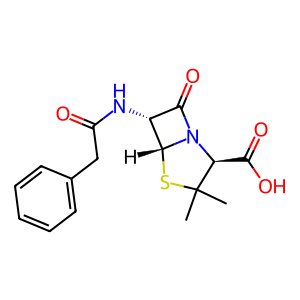

In [2]:
molecule_smiles = "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"
molecule = Chem.MolFromSmiles(molecule_smiles)

molecule_data = {
    "Generic Name": "Penicillin",
    "Formula": Chem.rdMolDescriptors.CalcMolFormula(molecule),
    "IUPAC Name": "(2S,5R,6R)-3,3-dimethyl-7-oxo-6-[(2-phenylacetyl)amino]-4-thia-1-azabicyclo[3.2.0]heptane-2-carboxylic acid",
    "CAS RN": "61-33-6",
    "SMILES": molecule_smiles,
    "InChI": Chem.MolToInchi(molecule),
}


print("Molecule Data:")
for key, value in molecule_data.items():
    print(f"{key}: {value}")

# Draw molecule
Draw.MolToImage(molecule)

## 2) SMILES 활용한 분자 데이터 변환
SMILES는 컴퓨터가 분자 구조를 쉽게 저장하고 처리할 수 있도록 설계되어 가장 보편적으로 사용되는 데이터 형식이다.

원자는 원소의 기호로 (ex: 탄소 -> C), 단일 결합을 제외한 이중, 삼중 결합은 (=, #)형태로 표기한다.

고리를 이루는 구조는 고리의 시작과 끝을 숫자로 (ex: 벤젠 -> c1ccccc1), 갈라지는 분기는 괄호로 (ex: CC(C)C) 표기한다.

수소는 표기를 생략하지만 암묵적으로 포함된 것으로 간주한다. 

이제, SMILES가 무엇인지 이해하였다면, 이것으로 어떻게 분자 데이터를 처리할 수 있는지 하나씩 살펴보도록 하자.

파이썬에서 SMILES는 주로 __RDkit 오픈 소스 라이브러리__ 를 통해 가공되기에 사용법에 익숙해지면 연구에 편리하다.    

### a) 문자열 기반 접근: String Tokenization
SMILES는 문자열이기에 자연어 처리에서 단어를 다루듯이 처리할 수 있다.

가장 간단한 예시로, 문자열을 __"개별적인 단위(토큰)"__ 로 분리하여 컴퓨터가 처리하기 쉽게 변환하는 것이다.

이 과정이 필요한 이유는, 머신러닝 및 딥러닝 모델에서 분자 데이털르 입력으로 사용하려면 SMILES를 숫자 벡터로 변환해야하기 때문이다.

이를 위해, SMILES를 __"의미 있는 조각"__ 으로 나누는 작업이 필요하다.

In [3]:
def generate_smiles_vocab(smiles):
    tokenizer = BasicSmilesTokenizer()
    smiles_tokens = sorted(set(tokenizer.tokenize(smiles)))
    smiles_vocab = {token: idx for idx, token in enumerate(smiles_tokens)}
    smiles_vocab['Unk'] = len(smiles_vocab)
    encoded_tokens = tokenizer.tokenize(smiles)
    encoded_smiles = [smiles_vocab[token] for token in encoded_tokens]
    return smiles_vocab, encoded_smiles

smiles_vocab, encoded_smiles = generate_smiles_vocab(molecule_smiles)

In [4]:
print(f"Original SMILES (페니실린):\n\t{molecule_smiles}\n")
print(f"SMILES Vocab (페니실린을 구성하는 의미를 가진 조각을 숫자로 맵핑하여 단어집을 형성):\n\t{smiles_vocab}\n")
print(f"Encoded SMILES by Vocab (페니실린에 SMILES를 위치별로 숫자 벡터 변환):\n\t{encoded_smiles}\n")

Original SMILES (페니실린):
	CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C

SMILES Vocab (페니실린을 구성하는 의미를 가진 조각을 숫자로 맵핑하여 단어집을 형성):
	{'(': 0, ')': 1, '1': 2, '2': 3, '3': 4, '=': 5, 'C': 6, 'N': 7, 'O': 8, 'S': 9, '[C@@H]': 10, '[C@H]': 11, 'Unk': 12}

Encoded SMILES by Vocab (페니실린에 SMILES를 위치별로 숫자 벡터 변환):
	[6, 6, 2, 0, 10, 0, 7, 3, 11, 0, 9, 2, 1, 10, 0, 6, 3, 5, 8, 1, 7, 6, 0, 5, 8, 1, 6, 6, 4, 5, 6, 6, 5, 6, 6, 5, 6, 4, 1, 6, 0, 5, 8, 1, 8, 1, 6]



### b) 지문 기반 접근: Figerprint
화학에서 __Fingerprint(지문)__ 는 분자의 화학적 구조나 특성을 간결하고 압축된 방식으로 표현한 이진 벡터 형식의 데이터이다.

이는 분자 간 유사성을 계산하거나 머신러닝 모델에서 분자 특성을 입력 데이터로 사용할 때 주로 활용되며

특정 칸에 임의의 구조를 정의하고 그 구조가 분자에 있다면 1, 없다면 0으로 값을 준다고 보면 되겠다.

분자 지문은 분석하는 방식에 따라 다양항 종류로 나뉜다.

* RDKFingerprint: 분자의 연결 정보를 중심으로 경로 방식으로 생성된 지문 (분자를 포괄적으로 분석하지만, 단순 경로 중심이기에 분자 간의 복잡한 관계 반영이 어려움)
* MACCS Keys: 166개의 고정된 패턴을 정의하여 생성된 지문 (간결하기에 계산이 빠르고 메모리 효율적, 표현에 대한 유연성은 낮음 - 새로운 화학 패턴을 반영할 수 없음) 
* Morgan Fingerprint: 특정 반지름(radius) 내의 원자와 결합 정보를 패턴으로 정의하여 지문을 생성 (ECFP로도 알려져 있으며, 반경 크기로 국소적 또는 전체적 특징을 자유롭게 표현 가능하지만 고정된 구조적 패턴이 없으므로 직관성이 떨어질 수 있음, 현재 머신러닝에서 가장 많이 사용되고 있는 방식)

아래 예시에서는 MACCS Keys를 제외한 나머지 지문의 비트를 128로 고정하여 육안상 전체적인 비트를 확인하기 쉽게 하였으나

일반적으로 사용되는 비트 수는 __1024__ 또는 __2048__ 이다. 

In [5]:
# RDKit Fingerprint
rdkit_fp = Chem.RDKFingerprint(molecule, fpSize=128)
print("RDKit Fingerprint:", '\n', list(rdkit_fp), '\n')

# MACCS Keys Fingerprint (167개로 고정된 차원, 비트 0은 항상 설정되지 않으며, 비트 1~166에만 설정됨)
maccs_fp = MACCSkeys.GenMACCSKeys(molecule)
print("MACCS Keys Fingerprint:", '\n', list(maccs_fp), '\n')

# Morgan Fingerprint (radius=2)
morgan_fp = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=128)
print("Morgan Fingerprint:", '\n', list(morgan_fp), '\n')

RDKit Fingerprint: 
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

MACCS Keys Fingerprint: 
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0] 

Morgan Fingerprint: 
 [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

[15:32:07] DEPRECATION WARNING: please use MorganGenerator


Morgan Fingerprint를 예시로 들어, 1로 표시된 부분이 어떤 구조를 나타내는지 시각화를 통해 확인할 수 있다.

In [6]:
drawOptions = Draw.rdMolDraw2D.MolDrawOptions()
drawOptions.prepareMolsBeforeDrawing = False

# to obtain smi
def getsmi(mol, bit, bit_info):
    if not bit in bit_info.keys():
        return None

    atomidx, radius = bit_info[bit][0]
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atomidx)

    atomsToUse = set((atomidx, ))
    for b in env:
        atomsToUse.add(mol.GetBondWithIdx(b).GetBeginAtomIdx())
        atomsToUse.add(mol.GetBondWithIdx(b).GetEndAtomIdx())

    enlargedEnv = set()
    for atom in atomsToUse:
        a = mol.GetAtomWithIdx(atom)
        for b in a.GetBonds():
          bidx = b.GetIdx()
          if bidx not in env:
            enlargedEnv.add(bidx)

    enlargedEnv = list(enlargedEnv)
    enlargedEnv += env

    # find all relevant neighbors
    anyAtoms = []
    for a in atomsToUse:
        neighbors = mol.GetAtomWithIdx(a).GetNeighbors()
        for n in neighbors:
            anyIdx = n.GetIdx()
            if anyIdx not in atomsToUse:
                anyAtoms.append(anyIdx)

    # replace atomic number to zero (there is no number for any atom)
    for aA in anyAtoms:
        mol.GetAtomWithIdx(aA).SetAtomicNum(0)

    submol = Chem.PathToSubmol(mol, enlargedEnv)

    # change [0] to *
    MorganBitSmiles = Chem.MolToSmiles(submol)
    MorganBitSmarts = Chem.MolToSmarts(submol).replace('[#0]', '*')
    return MorganBitSmiles, MorganBitSmarts



def visualize_bits(mol):
    bi = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=256, bitInfo=bi)
    tpls = [(mol, x, bi) for x in fp.GetOnBits()]
    img = Draw.DrawMorganBits(tpls, molsPerRow=10, legends=[str(x) for x in fp.GetOnBits()], drawOptions=drawOptions)
    plt.figure(figsize=(10, 10))
    plt.title("Morgan Fingerprint Visualization")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

[15:32:09] DEPRECATION WARNING: please use MorganGenerator


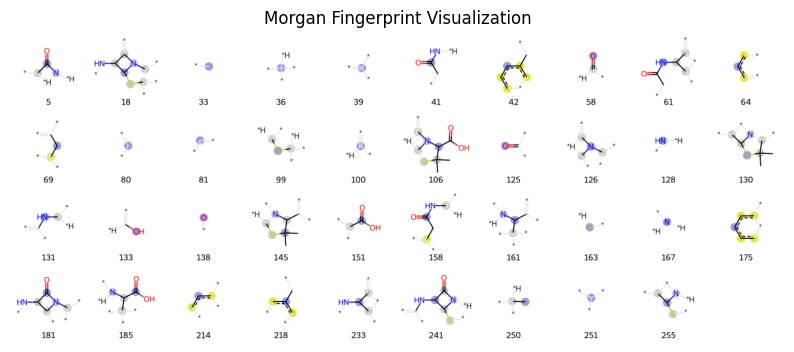

In [7]:
visualize_bits(molecule)

### c) 물리화학적 특성 기반 접근: Descriptor
Descriptor는 분자의 화학적, 물리적, 또는 생물학적 특성을 수치화한 __정량적 표현__ 값이다.

즉, 분자 구조와 관련된 정보를 수학적으로 변환하는 것이다.

간단한 예시로, 분자량 (Weight)는 분자를 구성하는 원자들의 무게 합을 의미한다.

LogP는 분자의 친수성/소수성 지표를 나타내는 값으로 용해도와 직접적으로 관련있는 수치이다.

Hydrogen Bond Donor/Acceptor는 분자가 수소 결합을 할 때, 어떤 원소가 전자를 주는/받는 입장인지 구분하고 그 개수를 계산한 것이다.

분자의 Descriptor는 굉장히 다양하며, 이는 RDkit 라이브러리를 통해 최대 210가지 정보를 계산할 수 있다.


In [8]:
descriptors = {
    "Molecular Weight": Descriptors.MolWt(molecule),
    "LogP": Descriptors.MolLogP(molecule),
    "Number of Hydrogen Bond Donors": Descriptors.NumHDonors(molecule),
    "Number of Hydrogen Bond Acceptors": Descriptors.NumHAcceptors(molecule),
}
print("Molecular Descriptors:")
for key, value in descriptors.items():
    print(f"{key}: {value}")

Molecular Descriptors:
Molecular Weight: 334.39700000000005
LogP: 0.8607999999999993
Number of Hydrogen Bond Donors: 2
Number of Hydrogen Bond Acceptors: 4


In [9]:
print('전체 Descriptors (210가지) :')
Descriptors.CalcMolDescriptors(molecule)

전체 Descriptors (210가지) :


{'MaxAbsEStateIndex': 12.268318846056943,
 'MaxEStateIndex': 12.268318846056943,
 'MinAbsEStateIndex': 0.20214151864449437,
 'MinEStateIndex': -1.007025845576982,
 'qed': 0.7977632704521286,
 'SPS': 28.0,
 'MolWt': 334.39700000000005,
 'HeavyAtomMolWt': 316.25300000000004,
 'ExactMolWt': 334.09872805599997,
 'NumValenceElectrons': 122,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.3273993847026587,
 'MinPartialCharge': -0.4796728023655438,
 'MaxAbsPartialCharge': 0.4796728023655438,
 'MinAbsPartialCharge': 0.3273993847026587,
 'FpDensityMorgan1': 1.3043478260869565,
 'FpDensityMorgan2': 1.9565217391304348,
 'FpDensityMorgan3': 2.5652173913043477,
 'BCUT2D_MWHI': 32.16690614916108,
 'BCUT2D_MWLOW': 9.956816977411961,
 'BCUT2D_CHGHI': 2.6362075433409933,
 'BCUT2D_CHGLO': -2.4313369018698783,
 'BCUT2D_LOGPHI': 2.5022450893783947,
 'BCUT2D_LOGPLOW': -2.7029184926640752,
 'BCUT2D_MRHI': 8.013146257169787,
 'BCUT2D_MRLOW': -0.16058803827234566,
 'AvgIpc': 2.741987834077,
 'BalabanJ': 1.6

### d) 이미지 기반 접근: 2D, 3D 이미지
분자 구조를 이미지 형식으로 변환하여 딥러닝 모델을 학습시키는 경우도 있다.

이 접근법은 분자 구조의 시각적 패턴을 학습하여 예측 작업을 수행할 수 있게 한다.

특히, CNN(Convolutional Neural Network)과 같은 이미지 처리에 특화된 모델에서 이 방식을 활용한다.

주의할 점으로 분자는 고정된 자세가 없으며, 3차원 형태도 있다는 것이다.

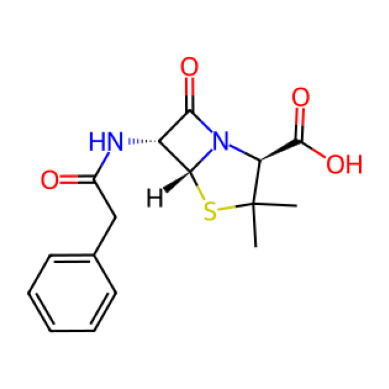

In [10]:
img = Draw.MolToImage(molecule)
plt.imshow(img)
plt.axis("off")
plt.show()

In [11]:
img.save("molecule_2D.png")
print("2D image saved as 'molecule_2D.png'")

2D image saved as 'molecule_2D.png'


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

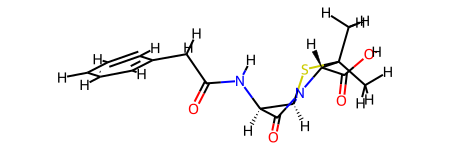

In [12]:
# Add hydrogens and generate 3D conformer
molecule_with_h = Chem.AddHs(molecule)

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.trackFailures = True
        
confs = rdDistGeom.EmbedMultipleConfs(molecule_with_h, 10) # ETKDG
molecule_with_h

In [13]:
with open("molecule_3D.html", "w") as f:
    f.write(view._make_html())
print("3D view saved as 'molecule_3D.html'")

3D view saved as 'molecule_3D.html'


### e) 그래프 기반 접근: Graph (2D, 3D)
분자 그래프(Molecular Graph)는 분자 구조를 그래프 형태로 표현한 것이다.

분자를 구성하는 원자는 그래프의 __노드(Node)__ 로, 원자 간 결합은 __엣지(Edge)__ 로 나타낸다.

이 표현은 분자의 연결 정보를 수학적으로 표현할 수 있을 뿐만 아니라, 3차원 구조까지 확장하여 반영할 수 있다.

특히, **Graph Neural Network(GNN)**를 활용해 분자를 처리하거나 분석하는 데 유용하다.

아래 간단한 예제에서 torch_geometric 라이브러리를 통한 분자 그래프 데이터를 __Data__ 객체로 만드는 작업을 해보자.

Data 안에는 다음과 같은 값들이 기본적으로 포함되며 상황에 따라 필요한 정보를 삽입하거나 제거할 수 있다.

* x: 그래프의 노드(원자)와 관련된 특성(feature)를 나타냄 (ex: [23, 9], 분자를 구성하는 23개의 노드가 존재하며 각 노드는 9차원의 특성 벡터를 가짐)
* edge_index: 그래프의 엣지(결합)을 정의하는 인덱스 배열 (ex: [2, 50], 50개의 연결 정보를 2차원 배열로 표현)
* edge_attr: 엣지(결합)의 특성(feature)을 나타냄 (ex: [50, 3], 50개의 엣지가 존재하며 각 엣지는 3차원의 특성 벡터를 가짐, 단일, 이중, 삼중 결합인지) 
* smiles: 그래프로 변환하기 전 SMILES 


In [14]:
graph_data = smiles.from_smiles(molecule_smiles)
graph_data

Data(x=[23, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles='CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C')

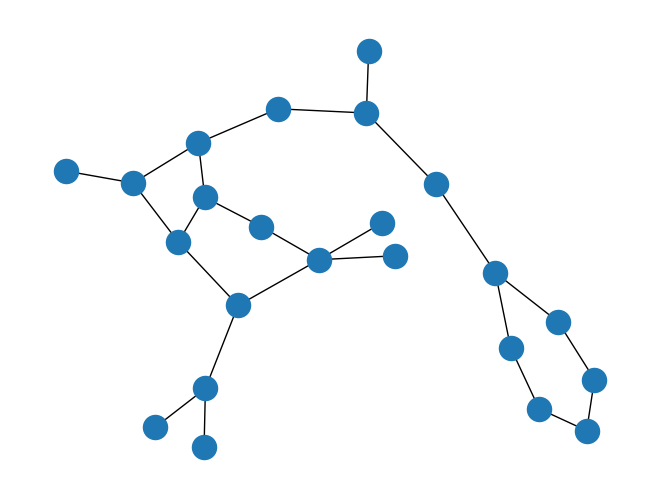

In [17]:
g = torch_geometric.utils.to_networkx(graph_data, to_undirected=True)
nx.draw(g)

### 3) 다양한 형태 변환을 할 수 있는 전체 함수

In [ ]:
def transform_mol(molecule_smiles, choice):
    molecule = Chem.MolFromSmiles(molecule_smiles)


    # string tokenization으로 변환
    if choice == 'string_tokenization' : # vocab dictionary, encoded smiles를 출력
        tokenizer = BasicSmilesTokenizer()
        smiles_tokens = sorted(set(tokenizer.tokenize(smiles)))
        smiles_vocab = {token: idx for idx, token in enumerate(smiles_tokens)}
        smiles_vocab['Unk'] = len(smiles_vocab)
        encoded_tokens = tokenizer.tokenize(smiles)
        encoded_smiles = [smiles_vocab[token] for token in encoded_tokens]
        return smiles_vocab, encoded_smiles
    

    # Fingerprint로 변환
    elif choice == 'rdkit_fingerprint' :
        rdkit_fp = Chem.RDKFingerprint(molecule)
        return list(rdkit_fp)
    
    elif choice == 'maccs_fingerprint':
        maccs_fp = MACCSkeys.GenMACCSKeys(molecule)
        return list(maccs_fp)
    
    elif choice == 'morgan_fingerprint':
        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024)
        return list(morgan_fp)
    

    # Descriptors로 변환
    elif choice == 'descriptors':
        return Descriptors.CalcMolDescriptors(molecule)
    

    # 2D image로 변환
    elif choice == '2D_image':
        img = Draw.MolToImage(molecule)
        img.save("molecule_2D.png") # 2D image 저장
        return img
    

    # 3D image로 변환
    elif choice == '3D_image':
        molecule_with_h = Chem.AddHs(molecule)
        EmbedMolecule(molecule_with_h)
        MMFFOptimizeMolecule(molecule_with_h)

        # Convert to 3D coordinates for visualization
        conf = molecule_with_h.GetConformer()
        atoms = molecule_with_h.GetAtoms()
        bonds = molecule_with_h.GetBonds()

        # Visualize in 3D using py3Dmol
        view = py3Dmol.view(width=400, height=400)

        for atom in atoms:
            pos = conf.GetAtomPosition(atom.GetIdx())
            view.addSphere({
                "center": {"x": pos.x, "y": pos.y, "z": pos.z},
                "radius": 0.3,
                "color": "blue" if atom.GetSymbol() == "H" else "gray",
            })

        for bond in bonds:
            begin = bond.GetBeginAtomIdx()
            end = bond.GetEndAtomIdx()
            pos1 = conf.GetAtomPosition(begin)
            pos2 = conf.GetAtomPosition(end)
            view.addCylinder({
                "start": {"x": pos1.x, "y": pos1.y, "z": pos1.z},
                "end": {"x": pos2.x, "y": pos2.y, "z": pos2.z},
                "radius": 0.1,
                "color": "black",
            })
        with open("molecule_3D.html", "w") as f: # 3D image 저장
            f.write(view._make_html())
        return view
    
    
    # 2D Graph로 변환
    elif choice == '2D_graph':
        graph_data = smiles.from_smiles(molecule_smiles)
        return graph_data
    
    elif choice == '3D_graph':
        return None


In [19]:
graph_2D = transform_mol(molecule_smiles, '2D_graph')
graph_2D

Data(x=[23, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles='CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C')

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
import rdkit
print(rdkit.__version__)

2024.03.6


In [3]:
esomeprazole = Chem.MolFromSmiles('COc1ccc2[n-]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1')
esomeprazole.GetNumConformers()

0

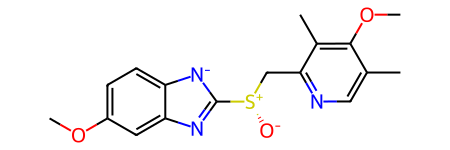

In [4]:
esomeprazole

In [5]:
esomeprazole = Chem.AddHs(esomeprazole) # <- add hydrogens so that we get a reasonable conformer
rdDistGeom.EmbedMolecule(esomeprazole)
print(esomeprazole.GetNumConformers(),esomeprazole.GetConformer().Is3D())

1 True


[15:39:43] UFFTYPER: Unrecognized charge state for atom: 8


In [6]:
rdDistGeom.EmbedMultipleConfs(esomeprazole,10, randomSeed=0xf00d) # <- generate 10 conformers
print(esomeprazole.GetNumConformers(),esomeprazole.GetConformer().Is3D())

[15:39:44] UFFTYPER: Unrecognized charge state for atom: 8


10 True


In [7]:
IPythonConsole.drawMol3D(esomeprazole)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
IPythonConsole.drawMol3D(esomeprazole,confId=2)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
!pip install py3Dmol